 # Astronomical Time Series Classification with PyTorch RNNs



 **Goal:** Classify synthetic light curves (time series) into different categories using Recurrent Neural Networks (RNNs) with PyTorch.



 **Context:** In astronomy, light curves (measurements of an object's brightness over time) are crucial for understanding the nature of celestial objects. Different types of variability exist (periodic stars, transient events, eclipsing binaries, etc.), and automatically classifying them is an important task. This notebook focuses on classifying three specific types: Cepheids, RR Lyrae, and Eclipsing Binaries, using the synthetic data generators provided.



 **Learning Approach:**

 1.  We will use **synthetic** light curve data for 7 classes (Cepheid, RR Lyrae, Eclipsing Binary, LPV/Mira, Flare Star and Rotational Modulation), generated using functions similar to those in astronomical research contexts. The dataset is designed to be *non-trivial*, moderately challenging simple RNN models.

 2.  We will implement and train basic **LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)** models (unidirectional, single-layer). We will observe their performance, which will likely be *improvable*.

 3.  **Main Exercise:** Participants will modify and enhance the basic LSTM/GRU architectures by introducing techniques like:

     *   Multiple Layers (`num_layers`)

     *   Bidirectionality (`bidirectional=True`)

     *   Dropout

     *   (Optional advanced: Attention, 1D Convolutions)

 4.  We will evaluate and compare the performance of the basic models against the enhanced models.



 **Notebook Outline:**

 1.  **Environment Setup:** Install and import libraries.

 2.  **Synthetic Dataset Generation and Preparation:** Create light curves using provided functions, split into train/validation/test, visualize, and create PyTorch DataLoaders.

 3.  **Base LSTM Model:** Define, train, and evaluate a simple LSTM.

 4.  **Base GRU Model:** Define, train, and evaluate a simple GRU.

 5.  **Exercise: Enhance RNN Architectures:** Modify the base models to achieve better performance.

 6.  **Exercise Solution (Example):** A sample implementation of an enhanced model.

 7.  **Comparison and Conclusions:** Comparative analysis of the results.

 ## 1. Environment Setup

In [1]:
# !pip install torch torchvision torchaudio numpy matplotlib scikit-learn torchmetrics seaborn pandas -q


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics # Make sure torchmetrics is installed

# Device setup (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)


Using device: cpu


In [ ]:
# Create directories (optional)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)


 ## 2. Synthetic Dataset Generation and Preparation



 We will create a synthetic dataset using the provided functions to generate light curves for three classes:



 1.  **Cepheid:** Pulsating variable stars with a characteristic asymmetric light curve shape.

 2.  **RR Lyrae:** Another type of pulsating variable star, typically with shorter periods and lower amplitudes than Cepheids, often with a sharp rise and slower decline.

 3.  **Eclipsing Binary:** Systems of two stars orbiting each other, where eclipses cause periodic dips in brightness.

 4.  **Delta Scuti (δ Sct):** Pulsating stars with very short periods (hours), often exhibiting multiple pulsation frequencies simultaneously (multi-periodic), resulting in complex light curve shapes with small amplitudes.

 5.  **LPV/Mira:** Long Period Variables, typically red giants, with very long pulsation periods (100s to 1000s of days), large amplitudes, often asymmetric shapes, and noticeable variations from one cycle to the next.

 6.  **Flare Star:** Stars exhibiting a relatively constant baseline brightness punctuated by sudden, sharp, short-lived, high-amplitude brightening events (flares).

 7.  **Rotational Modulation:** Stars showing quasi-periodic variations caused by features (like starspots) rotating in and out of view. The shape and amplitude can evolve over time as the features change.

In [4]:
# --- Light Curve Generation Functions (from the provided notebook) ---

def generate_cepheid(n_points=128, period=10, amplitude=1.5, noise_level=0.1):
    """Generate a Cepheid-like light curve with asymmetric variation"""
    time = np.sort(np.random.uniform(0, 100, n_points)) # Generate time points first
    phase = (time / period) % 1.0

    # Asymmetric sawtooth-like pattern
    # Flux calculation based on phase
    flux = 10 + amplitude * (0.5 - 0.5 * np.cos(2 * np.pi * phase) -
                           0.2 * np.sin(4 * np.pi * phase))

    # Add noise
    flux_err = np.ones_like(flux) * noise_level
    flux += np.random.normal(0, noise_level, size=len(time))

    # Return only flux and label for classification task
    return flux, 0 # Label 0 for Cepheid

def generate_rr_lyrae(n_points=128, period=0.6, amplitude=0.8, noise_level=0.1):
    """Generate an RR Lyrae-like light curve"""
    time = np.sort(np.random.uniform(0, 100, n_points))
    phase = (time / period) % 1.0

    # Sharper rise, slower decline
    flux = 10 + amplitude * (0.4 - 0.5 * np.cos(2 * np.pi * phase) -
                           0.3 * np.sin(2 * np.pi * phase))

    # Add noise
    flux_err = np.ones_like(flux) * noise_level
    flux += np.random.normal(0, noise_level, size=len(time))

    return flux, 1 # Label 1 for RR Lyrae

def generate_eclipsing_binary(n_points=128, period=3.2, primary_depth=0.5,
                               secondary_depth=0.2, noise_level=0.1):
    """Generate an eclipsing binary light curve with primary and secondary eclipses"""
    time = np.sort(np.random.uniform(0, 50, n_points)) # Use shorter time baseline typical for EB studies
    phase = (time / period) % 1.0

    # Generate flux
    flux = np.ones_like(time) * 10  # Base flux

    # Add primary eclipse (sharper dip)
    primary_mask = np.abs(phase - 0.0) < 0.05
    primary_phase_centered = phase[primary_mask] / 0.05 # Scale phase within eclipse duration
    primary_profile = primary_depth * (1 - primary_phase_centered**2) # Simple quadratic dip
    flux[primary_mask] -= primary_profile[primary_profile>0] # Ensure positive profile values


    # Add secondary eclipse (shallower dip)
    secondary_mask = np.abs(phase - 0.5) < 0.05
    secondary_phase_centered = (phase[secondary_mask] - 0.5) / 0.05 # Center phase at 0.5
    secondary_profile = secondary_depth * (1 - secondary_phase_centered**2)
    flux[secondary_mask] -= secondary_profile[secondary_profile>0]

    # Add noise
    flux_err = np.ones_like(flux) * noise_level
    flux += np.random.normal(0, noise_level, size=len(time))

    return flux, 2 # Label 2 for Eclipsing Binary

def generate_delta_scuti(n_points=128, baseline_flux=10,
                         periods_hours=[1.5, 1.8, 2.1], # Tipici periodi in ore
                         amplitudes=[0.03, 0.02, 0.015], # Piccole ampiezze (in unità di flusso relativo o magnitudini)
                         noise_level=0.005):

    if len(periods_hours) != len(amplitudes):
        raise ValueError("Le liste periods_hours e amplitudes devono avere la stessa lunghezza.")

    # Genera tempi - per pulsatori rapidi, un intervallo più breve ma denso è comune
    # Simuliamo osservazioni su ~2 giorni (48 ore)
    time_hours = np.sort(np.random.uniform(0, 48, n_points))

    total_signal = np.zeros(n_points)

    # Somma le componenti sinusoidali per ogni periodo
    for period_h, amp in zip(periods_hours, amplitudes):
        # Aggiungi una fase casuale per ciascuna componente
        phase_shift = np.random.uniform(0, 2 * np.pi)
        # Calcola il segnale per questo periodo
        signal = amp * np.sin(2 * np.pi * time_hours / period_h + phase_shift)
        total_signal += signal

    # Flusso finale = baseline + segnale multi-periodico + rumore
    flux = baseline_flux + total_signal + np.random.normal(0, noise_level, n_points)

    # Definisci un'etichetta numerica per questa classe
    label = 3 # Assegniamo 5 per Delta Scuti (assicurati che sia univoca)

    return flux, label

def generate_lpv_mira(n_points=128, baseline_flux=10,
                      period_days=300, amplitude=2.0, # Periodo lungo, ampiezza grande
                      asymmetry_param=0.3, # Controlla l'asimmetria (0 = sinusoidale, >0 salita più ripida)
                      cycle_variation_amp=0.3, # Frazione di variazione ampiezza ciclo-per-ciclo
                      cycle_variation_shape=0.1, # Variazione forma/asimmetria ciclo-per-ciclo
                      noise_level=0.1):

    # Genera tempi su un intervallo lungo per coprire diversi cicli
    max_time = period_days * np.random.uniform(3, 5) # Osserva per 3-5 periodi medi
    time_days = np.sort(np.random.uniform(0, max_time, n_points))

    # Calcola la fase *media*
    phase = (time_days / period_days) % 1.0

    # Simula variazioni ciclo-per-ciclo (lente)
    # Usiamo una sinusoide a lungo periodo per modulare i parametri
    long_period_mod = period_days * np.random.uniform(2.5, 4.0) # Periodo della modulazione
    amp_mod = 1.0 + cycle_variation_amp * np.sin(2 * np.pi * time_days / long_period_mod + np.random.uniform(0, np.pi))
    shape_mod = asymmetry_param * (1.0 + cycle_variation_shape * np.sin(2 * np.pi * time_days / long_period_mod + np.random.uniform(np.pi, 2*np.pi))) # Modula asimmetria

    current_amplitude = amplitude * amp_mod
    current_asymmetry = shape_mod

    # Crea il segnale base usando armoniche per l'asimmetria
    # Esempio: sin(x) + asymmetry * sin(2*x + phase_shift)
    signal = current_amplitude * (np.sin(2 * np.pi * phase) +
                                current_asymmetry * np.sin(4 * np.pi * phase + np.pi / 2)) # Aggiunge seconda armonica per asimmetria

    # Aggiusta la forma per renderla più simile a una Mira (es. salita più ripida)
    # Potrebbe richiedere modelli più complessi, ma questo dà un'idea
    # Per una salita più ripida, si potrebbero usare funzioni a tratti o template

    # Flusso finale = baseline + segnale + rumore
    flux = baseline_flux + signal + np.random.normal(0, noise_level * (1 + signal / baseline_flux / 2), n_points) # Rumore leggermente dipendente dal flusso?

    # Etichetta
    label = 4 # Assegniamo 6 per LPV/Mira

    return flux, label

def generate_flare_star(n_points=128, baseline_flux=10, flare_rate=0.05,
                       flare_amp_mean=3.0, flare_decay_time=0.5, noise_level=0.1):
    """Generate a flare star light curve."""
    time = np.linspace(0, 50, n_points) # Shorter baseline often used for flare studies
    dt = time[1] - time[0]
    flux = np.random.normal(baseline_flux, noise_level*0.5, n_points) # Baseline with some noise

    # Add flares (Poisson process approximation)
    n_flares = np.random.poisson(flare_rate * (time[-1] - time[0]))
    flare_times = np.random.uniform(time[0], time[-1], n_flares)

    for t_flare in flare_times:
        # Flare shape: Instant rise, exponential decay
        flare_amp = np.random.exponential(flare_amp_mean)
        flare_profile = flare_amp * np.exp(-(time - t_flare) / flare_decay_time)
        # Apply only after the flare time and add to flux
        flux[time >= t_flare] += flare_profile[time >= t_flare]

    # Add general noise
    flux += np.random.normal(0, noise_level, n_points)
    return flux, 5 # Label 3 for Flare Star

def generate_rotational_modulation(n_points=128, period=4.0, amplitude=0.3,
                                  amp_variation_frac=0.3, noise_level=0.1):
    """Generate a quasi-periodic light curve simulating rotational modulation."""
    time = np.sort(np.random.uniform(0, 100, n_points))
    base_flux = 10

    # Slowly varying amplitude
    long_period = np.random.uniform(30, 60) # Period of amplitude variation
    current_amplitude = amplitude * (1 + amp_variation_frac * np.sin(2 * np.pi * time / long_period))

    # Main periodic signal (rotation)
    phase = (time / period) % 1.0
    # Use a non-perfect sine wave, e.g., add a harmonic
    signal = current_amplitude * (np.sin(2 * np.pi * phase) + 0.3 * np.sin(4 * np.pi * phase + np.pi/3))

    flux = base_flux + signal
    # Add noise
    flux += np.random.normal(0, noise_level, n_points)
    return flux, 6 # Label 4 for Rotational Modulation


In [5]:
# --- Generate the full dataset ---

N_SAMPLES_PER_CLASS = 1000
TIME_SERIES_LENGTH = 128 # Should match n_points in generators
NOISE_LEVEL_GLOBAL = 0.15 # Global noise level adjustment if needed
NUM_CLASSES = 7
CLASS_NAMES = ['Cepheid', 'RR Lyrae', 'Eclipsing Binary', 'Delta Scuti', 'LPV', 'Flare Star', 'Rotational Mod']

all_series = []
all_labels = []

print("Generating synthetic data...")
for i in range(N_SAMPLES_PER_CLASS):
    # Cepheid - Vary parameters slightly for diversity
    cep_period = np.random.uniform(8, 12)
    cep_amp = np.random.uniform(1.3, 1.7)
    cep_flux, cep_label = generate_cepheid(n_points=TIME_SERIES_LENGTH, period=cep_period, amplitude=cep_amp, noise_level=NOISE_LEVEL_GLOBAL)
    all_series.append(cep_flux)
    all_labels.append(cep_label)

    # RR Lyrae - Vary parameters
    rr_period = np.random.uniform(0.5, 0.7)
    rr_amp = np.random.uniform(0.7, 0.9)
    rr_flux, rr_label = generate_rr_lyrae(n_points=TIME_SERIES_LENGTH, period=rr_period, amplitude=rr_amp, noise_level=NOISE_LEVEL_GLOBAL*0.8) # Slightly less noisy?
    all_series.append(rr_flux)
    all_labels.append(rr_label)

    # Eclipsing Binary - Vary parameters
    eb_period = np.random.uniform(2.8, 3.6)
    eb_pdepth = np.random.uniform(0.4, 0.6)
    eb_sdepth = np.random.uniform(0.1, 0.3)
    eb_flux, eb_label = generate_eclipsing_binary(n_points=TIME_SERIES_LENGTH, period=eb_period, primary_depth=eb_pdepth, secondary_depth=eb_sdepth, noise_level=NOISE_LEVEL_GLOBAL*1.2) # Slightly more noisy?
    all_series.append(eb_flux)
    all_labels.append(eb_label)
    if (i+1) % (N_SAMPLES_PER_CLASS // 10) == 0:
        print(f"  Generated {3*(i+1)} samples...")
    
    # Delta Scuti
    ds_periods = sorted(np.random.uniform(0.5, 4.0, np.random.randint(2, 5))) # 2-4 random periods in hours
    ds_amps = sorted(np.random.exponential(0.02, len(ds_periods)), reverse=True) # Esponential amplitudes 
    ds_noise = np.random.uniform(0.003, 0.008)
    ds_flux, ds_label = generate_delta_scuti(n_points=TIME_SERIES_LENGTH, periods_hours=ds_periods, amplitudes=ds_amps, noise_level=ds_noise)
    all_series.append(ds_flux)
    all_labels.append(ds_label)

    # LPV/Mira
    lpv_period = np.random.uniform(200, 500)
    lpv_amp = np.random.uniform(1.5, 3.0)
    lpv_asym = np.random.uniform(0.2, 0.5)
    lpv_noise = np.random.uniform(0.08, 0.2)
    lpv_flux, lpv_label = generate_lpv_mira(n_points=TIME_SERIES_LENGTH, period_days=lpv_period, amplitude=lpv_amp, asymmetry_param=lpv_asym, noise_level=lpv_noise)
    all_series.append(lpv_flux)
    all_labels.append(lpv_label)

    # Flare Star
    fs_amp = np.random.uniform(2.0, 4.0)
    fs_decay = np.random.uniform(0.3, 0.7)
    fs_flux, fs_label = generate_flare_star(n_points=TIME_SERIES_LENGTH, flare_amp_mean=fs_amp, flare_decay_time=fs_decay, noise_level=NOISE_LEVEL_GLOBAL*0.7)
    all_series.append(fs_flux)
    all_labels.append(fs_label)

    # Rotational Modulation
    rm_period = np.random.uniform(3.0, 5.0)
    rm_amp = np.random.uniform(0.2, 0.4)
    rm_flux, rm_label = generate_rotational_modulation(n_points=TIME_SERIES_LENGTH, period=rm_period, amplitude=rm_amp, noise_level=NOISE_LEVEL_GLOBAL)
    all_series.append(rm_flux)
    all_labels.append(rm_label)

    # Update progress print statement if needed (depends on N_SAMPLES_PER_CLASS)
    if (i+1) % (N_SAMPLES_PER_CLASS // 10) == 0:
         print(f"  Generated {NUM_CLASSES*(i+1)} samples...") # Use NUM_CLASSES


# Convert to NumPy arrays and shuffle
all_series = np.array(all_series)
all_labels = np.array(all_labels)
indices = np.arange(len(all_labels))
np.random.shuffle(indices)

series_data = all_series[indices]
labels_data = all_labels[indices]

print(f"\nGenerated data shape: {series_data.shape}")
print(f"Generated labels shape: {labels_data.shape}")
print(f"Unique labels: {np.unique(labels_data)}")



Generating synthetic data...
  Generated 300 samples...
  Generated 700 samples...
  Generated 600 samples...
  Generated 1400 samples...
  Generated 900 samples...
  Generated 2100 samples...
  Generated 1200 samples...
  Generated 2800 samples...
  Generated 1500 samples...
  Generated 3500 samples...
  Generated 1800 samples...
  Generated 4200 samples...
  Generated 2100 samples...
  Generated 4900 samples...
  Generated 2400 samples...
  Generated 5600 samples...
  Generated 2700 samples...
  Generated 6300 samples...
  Generated 3000 samples...
  Generated 7000 samples...

Generated data shape: (7000, 128)
Generated labels shape: (7000,)
Unique labels: [0 1 2 3 4 5 6]


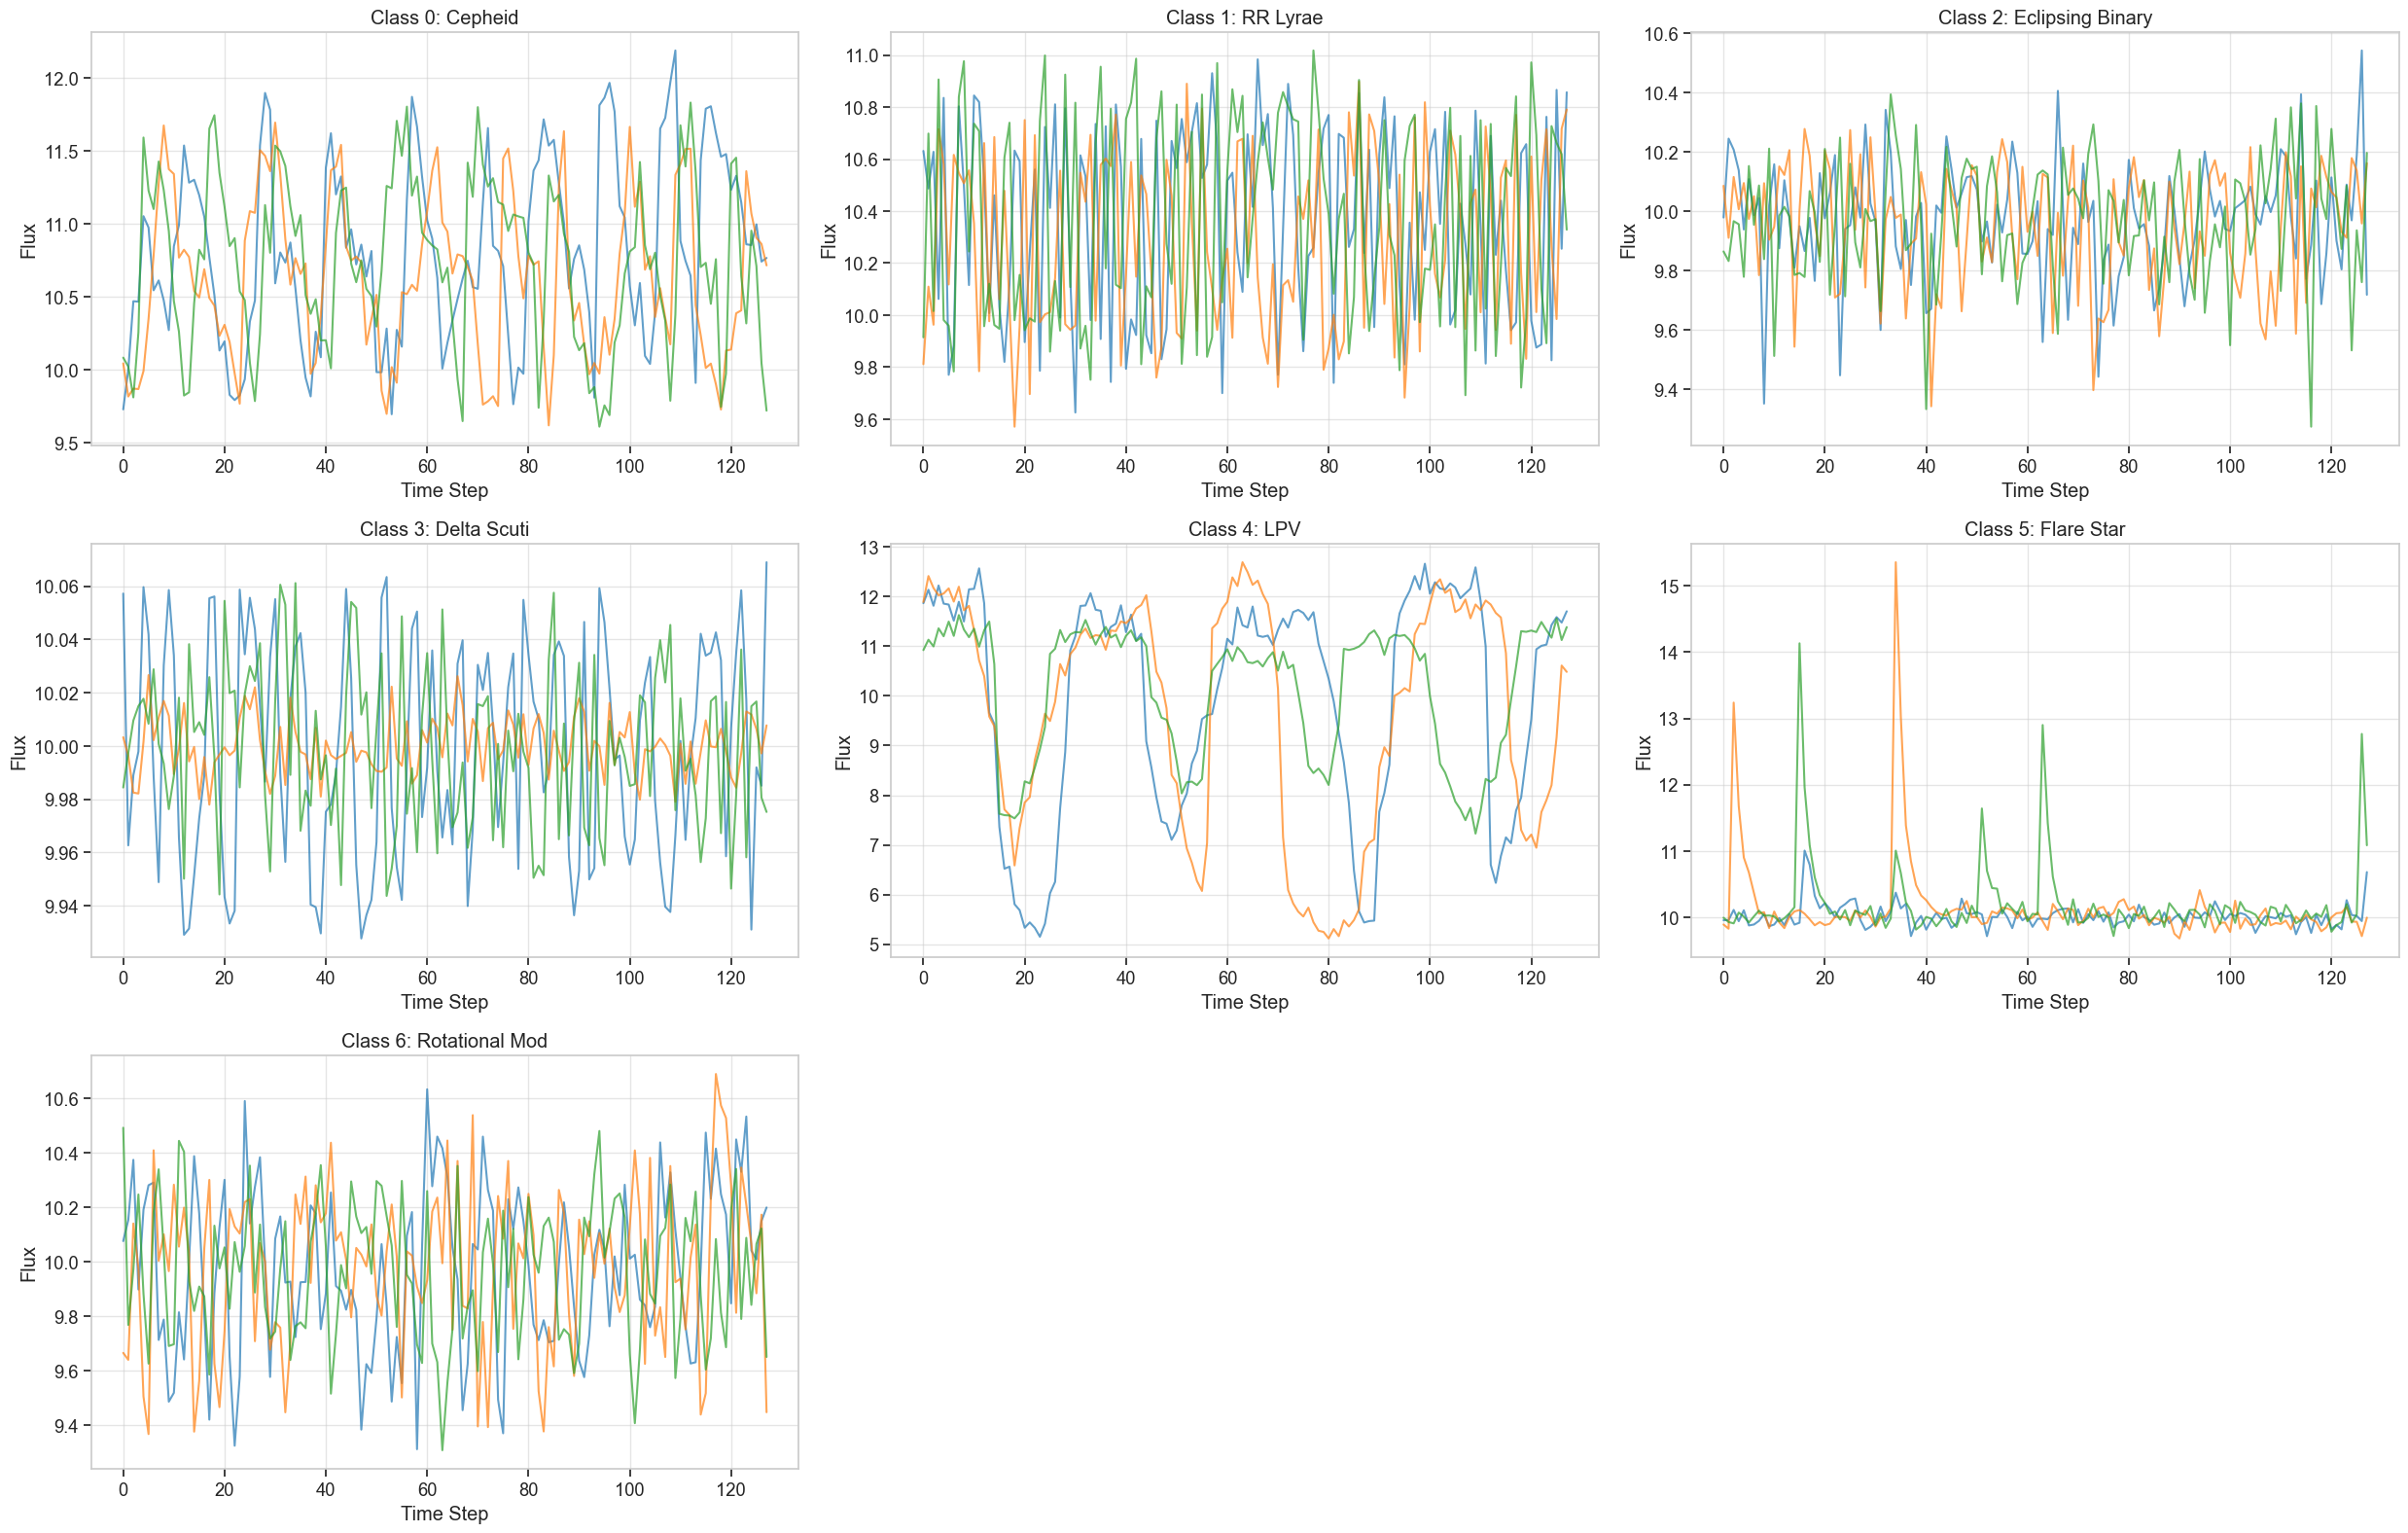

In [6]:
# --- Data Visualization ---
plt.figure(figsize=(25, 16)) # Increased height
time_axis = np.arange(TIME_SERIES_LENGTH)

for i, class_name in enumerate(CLASS_NAMES):
    # >>>>> Use 2 rows, 3 columns <<<<<
    plt.subplot(3, 3, i + 1)
    idxs = np.where(labels_data == i)[0][:3] # Show 3 examples
    if len(idxs) > 0: # Check if examples exist for this class
        for idx in idxs:
            plt.plot(time_axis, series_data[idx], alpha=0.7)
        plt.title(f"Class {i}: {class_name}")
    else:
        plt.title(f"Class {i}: {class_name}\n(No samples found?)") # Handle case if a class wasn't generated properly
    plt.xlabel("Time Step")
    plt.ylabel("Flux")
    plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()


In [7]:
# --- Train/Validation/Test Split ---
# Stratify to maintain class proportions
X_train_val, X_test, y_train_val, y_test = train_test_split(
    series_data, labels_data, test_size=0.15, random_state=SEED, stratify=labels_data
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15 / 0.85, random_state=SEED, stratify=y_train_val # ~15% of total for validation
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"Label distribution (Train): {np.bincount(y_train)}")
print(f"Label distribution (Validation): {np.bincount(y_val)}")
print(f"Label distribution (Test): {np.bincount(y_test)}")



Train set: (4900, 128), (4900,)
Validation set: (1050, 128), (1050,)
Test set: (1050, 128), (1050,)
Label distribution (Train): [700 700 700 700 700 700 700]
Label distribution (Validation): [150 150 150 150 150 150 150]
Label distribution (Test): [150 150 150 150 150 150 150]


In [8]:
# --- Preprocessing: Standardization ---
# Scaling is important for neural networks.
# Fit the scaler ONLY on the training data.
scaler = StandardScaler()

# Reshape for scaler: Needs 2D [n_samples * seq_len, 1] or [n_samples, seq_len]
# Let's scale each time series independently first, then maybe standardize across the dataset?
# Simpler approach: Treat each sample's sequence as features for the scaler.
# Fit on flattened training data
scaler.fit(X_train.reshape(-1, 1))

# Transform train, val, test
X_train_scaled = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)


# Add the feature dimension (required by PyTorch RNNs/CNNs: [batch, seq_len, features])
X_train_scaled = X_train_scaled[:, :, np.newaxis]
X_val_scaled = X_val_scaled[:, :, np.newaxis]
X_test_scaled = X_test_scaled[:, :, np.newaxis]

print(f"\nScaled train shape with feature dim: {X_train_scaled.shape}")
print(f"Mean after scaling (Train sample 0): {X_train_scaled[0].mean():.4f}") # Should be close to 0
print(f"Std after scaling (Train sample 0): {X_train_scaled[0].std():.4f}")   # Should be close to 1




Scaled train shape with feature dim: (4900, 128, 1)
Mean after scaling (Train sample 0): 0.6740
Std after scaling (Train sample 0): 0.7161


In [9]:
# --- PyTorch Dataset and DataLoader Creation ---

class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series."""
    def __init__(self, series, labels, transform=None):
        # Ensure data is float32 for PyTorch tensors
        self.series = torch.tensor(series, dtype=torch.float32)
        # Ensure labels are long for CrossEntropyLoss
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform # Optional: for any further transformations

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.series[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        # PyTorch RNNs expect [seq_len, features] or [batch, seq_len, features]
        # Our data is already [seq_len, features] per sample
        return sample, label

# Create Datasets
train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) # os.cpu_count() // 2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # os.cpu_count() // 2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # os.cpu_count() // 2, pin_memory=True)

# Verify a batch
try:
    data_iter = iter(train_loader)
    sample_batch, label_batch = next(data_iter)
    print(f"\nSample batch shape: {sample_batch.shape}") # [batch_size, seq_len, num_features]
    print(f"Label batch shape: {label_batch.shape}")
except Exception as e:
    print(f"\nError fetching batch, check DataLoader setup: {e}")




Sample batch shape: torch.Size([64, 128, 1])
Label batch shape: torch.Size([64])


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


 ## 3. Base LSTM Model



 We define a very simple LSTM classifier:

 *   A single, unidirectional LSTM layer.

 *   A fully-connected linear layer for the final classification.



 We expect decent but not optimal performance, given the dataset's design.

In [10]:
class LSTMBaseClassifier(nn.Module):
    """Base (Simple) LSTM Classifier."""
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=NUM_CLASSES, dropout_prob=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        # batch_first=True means input is (batch, seq_len, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob, bidirectional=False)

        # Linear layer for classification
        self.fc = nn.Linear(hidden_size, num_classes) # Only hidden_size because unidirectional

    def forward(self, x):
        # Initialize hidden and cell states (optional, defaults to zeros if not provided)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass through LSTM
        # lstm_out contains output for each timestep
        # h_n is the final hidden state, c_n is the final cell state
        lstm_out, (h_n, c_n) = self.lstm(x) #, (h0, c0))

        # We use the output of the last hidden state of the last layer for classification
        # h_n has shape [num_layers * num_directions, batch, hidden_size]
        # We want the last layer -> h_n[-1] for unidirectional
        last_hidden_state = h_n[-1]

        # Pass through the linear layer
        out = self.fc(last_hidden_state)
        return out


In [11]:
# --- Helper Functions for Training and Evaluation ---

def train_epoch(model, dataloader, criterion, optimizer, device, metrics_calculator):
    """Runs one training epoch."""
    model.train() # Set model to training mode
    metrics_calculator.reset()
    total_loss = 0.0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics and loss
        total_loss += loss.item() * data.size(0) # Accumulate loss for the epoch
        # Detach output before passing to metrics to prevent gradient tracking issues
        metrics_calculator.update(output.detach(), target)

    avg_loss = total_loss / len(dataloader.dataset)
    metrics = metrics_calculator.compute()
    return avg_loss, metrics

def validate_epoch(model, dataloader, criterion, device, metrics_calculator):
    """Runs one validation epoch."""
    model.eval() # Set model to evaluation mode
    metrics_calculator.reset()
    total_loss = 0.0

    with torch.no_grad(): # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            metrics_calculator.update(output, target)

    avg_loss = total_loss / len(dataloader.dataset)
    metrics = metrics_calculator.compute()
    return avg_loss, metrics

def run_train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, model_name="best_model.pth", patience=5):
    """Main training loop with early stopping."""
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Initialize metrics calculators (per epoch)
    # Using Accuracy and F1-Score (macro average suitable for potentially imbalanced classes)
    metrics_train = torchmetrics.MetricCollection({
        'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES),
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
    }).to(device)

    metrics_val = torchmetrics.MetricCollection({
        'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES),
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
    }).to(device)


    for epoch in range(num_epochs):
        # Training
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, metrics_train)
        train_losses.append(train_loss)
        # Convert tensor metric to Python float
        train_acc = train_metrics['accuracy'].item()
        train_f1 = train_metrics['f1'].item()
        train_accs.append(train_acc)


        # Validation
        val_loss, val_metrics = validate_epoch(model, val_loader, criterion, device, metrics_val)
        val_losses.append(val_loss)
        val_acc = val_metrics['accuracy'].item()
        val_f1 = val_metrics['f1'].item()
        val_accs.append(val_acc)


        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Early Stopping and Best Model Saving (based on validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_name)
            print(f"   -> Validation loss decreased. Saved best model to {model_name}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"   -> Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
            break

    history = {'train_loss': train_losses, 'val_loss': val_losses,
               'train_acc': train_accs, 'val_acc': val_accs}
    return history

def run_test(model, dataloader, criterion, device, class_names, model_path="best_model.pth"):
    """Evaluates the model on the test set."""
    try:
        # Load the best saved model
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Cannot evaluate.")
        return None
    except Exception as e:
        print(f"Error loading model state: {e}. Cannot evaluate.")
        return None


    # Metrics for the test set
    test_metrics = torchmetrics.MetricCollection({
        'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names)).to(device),
        'f1_macro': torchmetrics.F1Score(task="multiclass", num_classes=len(class_names), average='macro').to(device),
        'f1_weighted': torchmetrics.F1Score(task="multiclass", num_classes=len(class_names), average='weighted').to(device),
        'conf_matrix': torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)
    }).to(device)
    test_metrics.reset()

    total_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            preds = torch.argmax(output, dim=1)
            test_metrics.update(preds, target) # Note: torchmetrics expects (preds, target)

            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    avg_loss = total_loss / len(dataloader.dataset)
    final_metrics = test_metrics.compute()

    # Extract metrics safely, converting to CPU and Python float/numpy array
    accuracy = final_metrics['accuracy'].cpu().item()
    f1_macro = final_metrics['f1_macro'].cpu().item()
    f1_weighted = final_metrics['f1_weighted'].cpu().item()
    conf_matrix_tensor = final_metrics['conf_matrix'].cpu() # Keep as tensor for now
    conf_matrix_np = conf_matrix_tensor.numpy() # Convert to numpy for display

    print("\n--- Test Set Evaluation ---")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Macro): {f1_macro:.4f}")
    print(f"Test F1 Score (Weighted): {f1_weighted:.4f}")

    print("\nClassification Report:")
    # Ensure target_names matches the number of classes inferred from labels
    unique_labels = sorted(np.unique(all_targets))
    report_class_names = [class_names[i] for i in unique_labels]
    print(classification_report(all_targets, all_preds, target_names=report_class_names, digits=4))

    print("\nConfusion Matrix:")
    plt.figure(figsize=(len(class_names)*1.8, len(class_names)*1.5))
    sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
                xticklabels=report_class_names, yticklabels=report_class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    # Return metrics including the confusion matrix tensor
    return {
        'loss': avg_loss,
        'accuracy': final_metrics['accuracy'], # Keep as tensor
        'f1_macro': final_metrics['f1_macro'], # Keep as tensor
        'f1_weighted': final_metrics['f1_weighted'], # Keep as tensor
        'conf_matrix': conf_matrix_tensor
    }

def draw_metric_hist(history, title='Model Training History'):
    """Draws learning curves."""
    if not history or 'train_loss' not in history or not history['train_loss']:
        print("History object is empty or missing data. Cannot plot.")
        return

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    if 'val_loss' in history and history['val_loss']:
      plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    if 'val_acc' in history and history['val_acc']:
      plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for global title
    plt.show()


In [12]:
# --- Train Base LSTM ---

# Instantiate Model, Loss, Optimizer
lstm_base_model = LSTMBaseClassifier(input_size=1, hidden_size=64, num_layers=1, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification
optimizer_lstm_base = optim.Adam(lstm_base_model.parameters(), lr=0.0001)

print("--- Training Base LSTM Model ---")
# Reduce epochs for faster workshop execution, add patience for early stopping
NUM_EPOCHS = 15 # ADJUST FOR WORKSHOP TIME (e.g., 5-15)
PATIENCE = 3 # Stop after 3 epochs with no validation loss improvement

lstm_base_history = run_train(lstm_base_model, train_loader, val_loader, criterion, optimizer_lstm_base,
                              device, num_epochs=NUM_EPOCHS, model_name="lstm_base_best.pth", patience=PATIENCE)


--- Training Base LSTM Model ---


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/15 | Train Loss: 1.9433, Train Acc: 0.1898, Train F1: 0.1091 | Val Loss: 1.9366, Val Acc: 0.1924, Val F1: 0.1152
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 2/15 | Train Loss: 1.9326, Train Acc: 0.1904, Train F1: 0.1135 | Val Loss: 1.9227, Val Acc: 0.2143, Val F1: 0.1357
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 3/15 | Train Loss: 1.9115, Train Acc: 0.2294, Train F1: 0.1471 | Val Loss: 1.8833, Val Acc: 0.3305, Val F1: 0.2560
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 4/15 | Train Loss: 1.7464, Train Acc: 0.3518, Train F1: 0.2533 | Val Loss: 1.6199, Val Acc: 0.3190, Val F1: 0.1883
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 5/15 | Train Loss: 1.5397, Train Acc: 0.3067, Train F1: 0.2017 | Val Loss: 1.4739, Val Acc: 0.2971, Val F1: 0.1620
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 6/15 | Train Loss: 1.4600, Tr

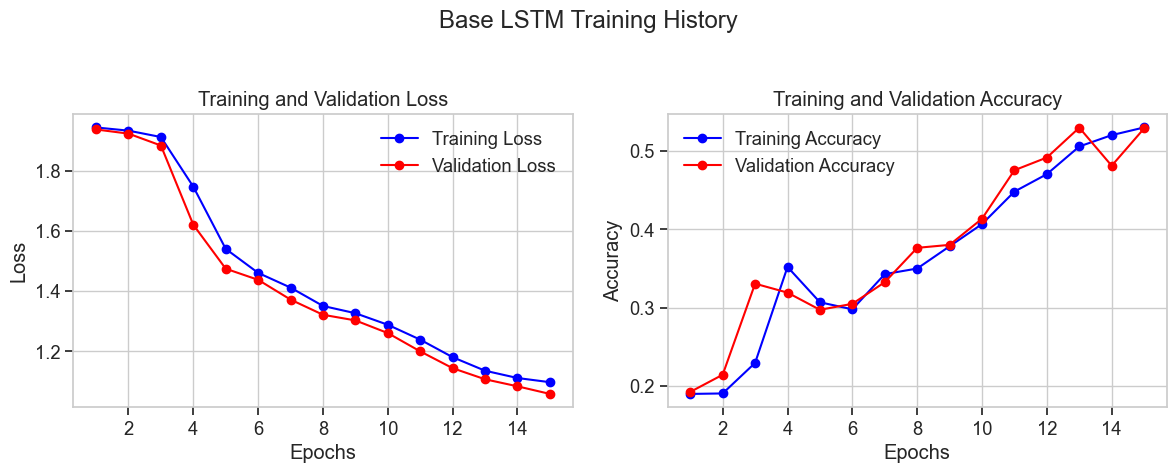

In [13]:
# --- Plot Base LSTM Learning Curves ---
draw_metric_hist(lstm_base_history, title='Base LSTM Training History')



--- Test Set Evaluation ---
Test Loss: 1.0719
Test Accuracy: 0.5238
Test F1 Score (Macro): 0.4478
Test F1 Score (Weighted): 0.4478

Classification Report:
                  precision    recall  f1-score   support

         Cepheid     0.7081    0.9867    0.8245       150
        RR Lyrae     0.9556    0.5733    0.7167       150
Eclipsing Binary     0.0000    0.0000    0.0000       150
     Delta Scuti     0.2604    1.0000    0.4132       150
             LPV     0.9675    0.9933    0.9803       150
      Flare Star     0.8500    0.1133    0.2000       150
  Rotational Mod     0.0000    0.0000    0.0000       150

        accuracy                         0.5238      1050
       macro avg     0.5345    0.5238    0.4478      1050
    weighted avg     0.5345    0.5238    0.4478      1050


Confusion Matrix:


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

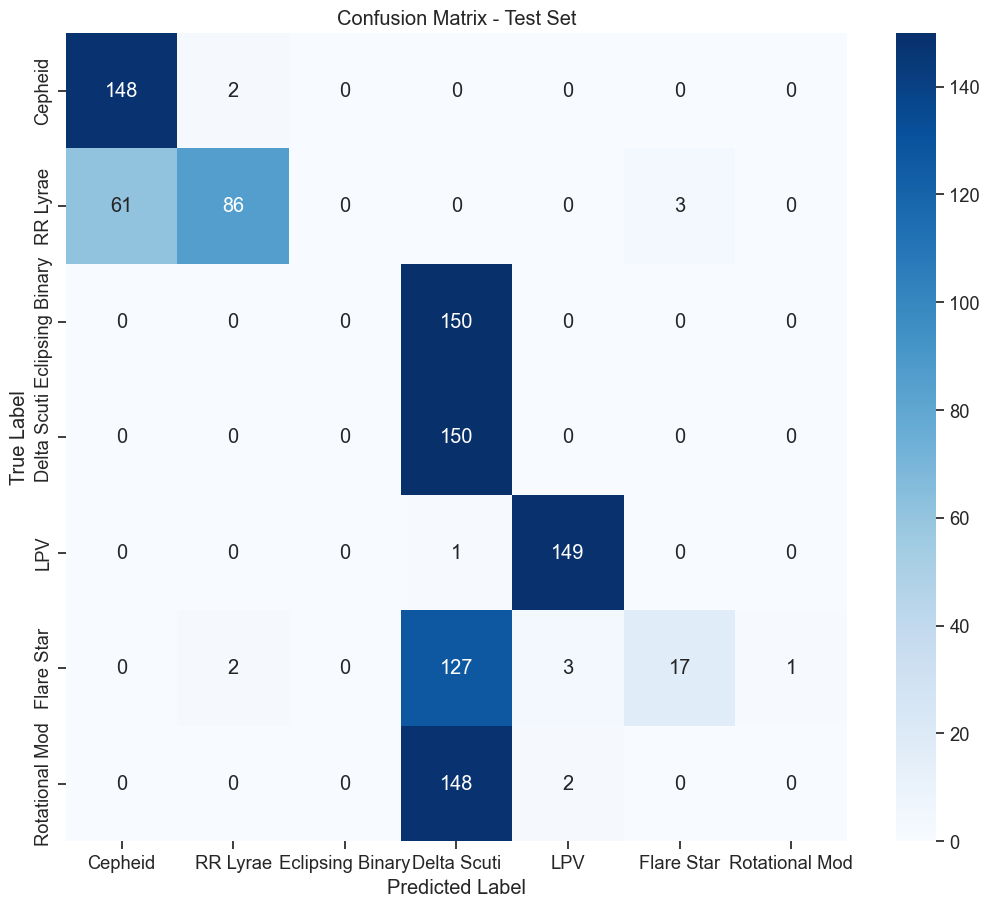

In [14]:
# --- Evaluate Base LSTM on Test Set ---
lstm_base_test_metrics = run_test(lstm_base_model, test_loader, criterion, device,
                                  class_names=CLASS_NAMES, model_path="lstm_base_best.pth")


 **Base LSTM Comments:** Observe the metrics (accuracy, F1, confusion matrix). The model likely learned something, but there might be significant errors, especially between classes with subtle differences or requiring understanding of longer-term patterns or specific event shapes (like eclipses). This indicates room for improvement.

 ## 4. Base GRU Model



 Now, let's implement a base GRU model, structurally similar to the base LSTM (single layer, unidirectional), to see if GRU performs differently on this task.

In [15]:
class GRUBaseClassifier(nn.Module):
    """Base (Simple) GRU Classifier."""
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=NUM_CLASSES, dropout_prob=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout_prob, bidirectional=False)

        # Linear layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Pass through GRU
        # GRU output: output, h_n (h_n is the last hidden state)
        gru_out, h_n = self.gru(x)

        # Use the last hidden state of the last layer
        last_hidden_state = h_n[-1]

        # Pass through the linear layer
        out = self.fc(last_hidden_state)
        return out


In [16]:
# --- Train Base GRU ---
gru_base_model = GRUBaseClassifier(input_size=1, hidden_size=64, num_layers=1, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss() # Reuse the same loss function
optimizer_gru_base = optim.Adam(gru_base_model.parameters(), lr=0.0001)

print("\n--- Training Base GRU Model ---")
gru_base_history = run_train(gru_base_model, train_loader, val_loader, criterion, optimizer_gru_base,
                             device, num_epochs=NUM_EPOCHS, model_name="gru_base_best.pth", patience=PATIENCE)



--- Training Base GRU Model ---


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/15 | Train Loss: 1.9503, Train Acc: 0.1082, Train F1: 0.0570 | Val Loss: 1.9420, Val Acc: 0.1429, Val F1: 0.0407
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 2/15 | Train Loss: 1.9348, Train Acc: 0.1643, Train F1: 0.0697 | Val Loss: 1.9260, Val Acc: 0.1905, Val F1: 0.0930
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 3/15 | Train Loss: 1.9150, Train Acc: 0.2273, Train F1: 0.1154 | Val Loss: 1.8990, Val Acc: 0.2486, Val F1: 0.1232
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 4/15 | Train Loss: 1.8395, Train Acc: 0.2810, Train F1: 0.1443 | Val Loss: 1.6699, Val Acc: 0.3029, Val F1: 0.1639
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 5/15 | Train Loss: 1.5701, Train Acc: 0.3006, Train F1: 0.1606 | Val Loss: 1.4725, Val Acc: 0.3076, Val F1: 0.1723
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 6/15 | Train Loss: 1.4238, Train A

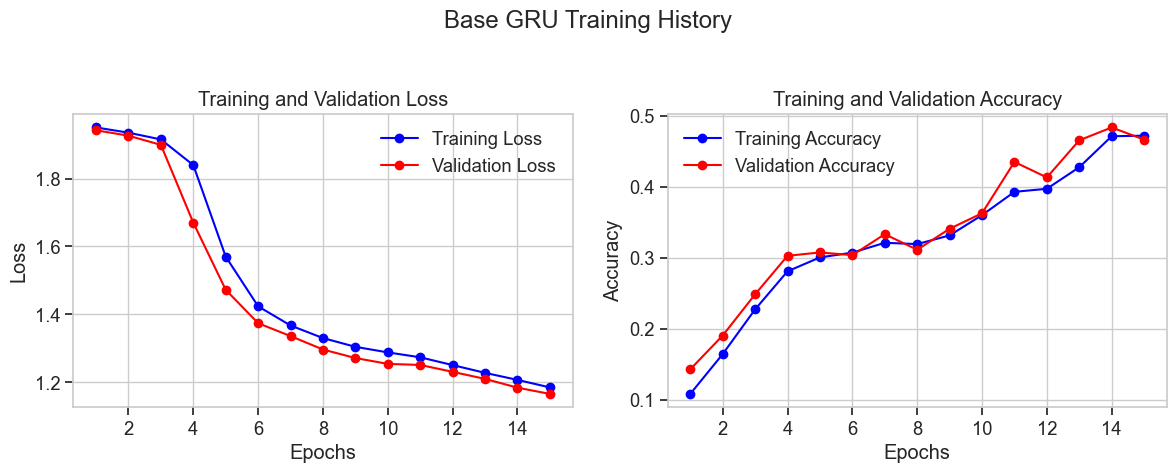

In [17]:
# --- Plot Base GRU Learning Curves ---
draw_metric_hist(gru_base_history, title='Base GRU Training History')



--- Test Set Evaluation ---
Test Loss: 1.1731
Test Accuracy: 0.4781
Test F1 Score (Macro): 0.4201
Test F1 Score (Weighted): 0.4201

Classification Report:
                  precision    recall  f1-score   support

         Cepheid     0.6356    1.0000    0.7772       150
        RR Lyrae     0.9324    0.9200    0.9262       150
Eclipsing Binary     0.2520    0.8267    0.3863       150
     Delta Scuti     0.0119    0.0067    0.0085       150
             LPV     1.0000    0.4933    0.6607       150
      Flare Star     1.0000    0.1000    0.1818       150
  Rotational Mod     0.0000    0.0000    0.0000       150

        accuracy                         0.4781      1050
       macro avg     0.5474    0.4781    0.4201      1050
    weighted avg     0.5474    0.4781    0.4201      1050


Confusion Matrix:


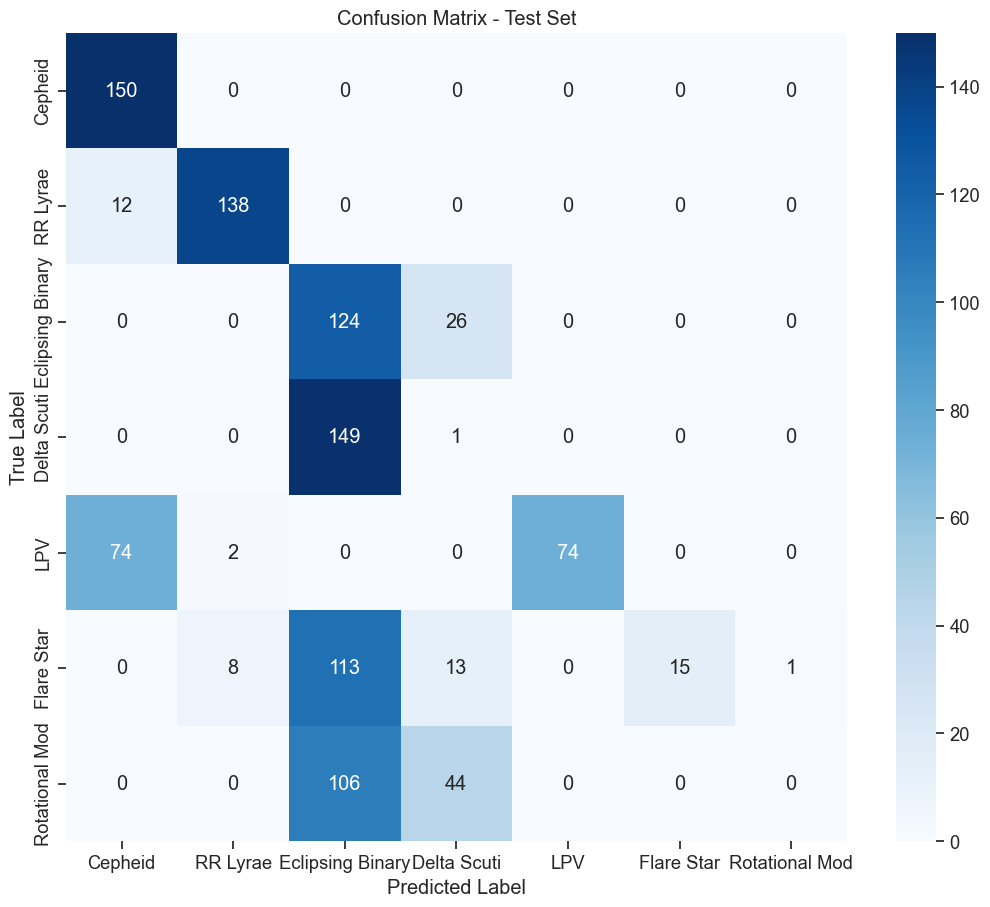

In [18]:
# --- Evaluate Base GRU on Test Set ---
gru_base_test_metrics = run_test(gru_base_model, test_loader, criterion, device,
                                 class_names=CLASS_NAMES, model_path="gru_base_best.pth")


 **Base GRU Comments:** Compare the GRU base performance with the LSTM base. Often, GRU trains slightly faster and might perform better or worse depending on the dataset. Again, we should likely see potential for improvement.

 ## 5. Exercise: Enhance RNN Architectures



 **Your Task:** Now it's time to enhance the RNN models! The base models are intentionally simple (unidirectional, 1 layer). This limits their ability to:

 *   Capture hierarchical temporal dependencies (addressable with `num_layers > 1`).

 *   Use information from both past and future context at a given time step (addressable with `bidirectional=True`).

 *   Manage overfitting in more complex models (mitigated with `dropout`).



 **Goal:** Modify the `LSTMBaseClassifier` or `GRUBaseClassifier` classes (or create new ones, e.g., `GRUlassifier`) to include **at least one** of the following techniques:



 1.  **Multiple Layers:** Set `num_layers` to 2 or more in the `nn.LSTM` or `nn.GRU` initialization.

     *   *Note:* The hidden state output `h_n` will have shape `[num_layers * num_directions, batch, hidden_size]`. To use only the last state of the *last layer*, you need to select it correctly (e.g., `h_n[-1]` if unidirectional, or combine `h_n[-1]` and `h_n[-2]` if bidirectional and taking the last layer's forward and backward states).

 2.  **Bidirectionality:** Set `bidirectional=True`.

     *   *Important:* The RNN output (e.g., `gru_out`) will now have shape `[batch, seq_len, hidden_size * 2]`.

     *   *Important:* The hidden state `h_n` will have shape `[num_layers * 2, batch, hidden_size]`.

     *   *Important:* The subsequent linear layer (`nn.Linear`) **must** now accept an input dimension of `hidden_size * 2` if you use the concatenated hidden states (e.g., `torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)`) or the output of the last time step (`lstm_out[:, -1, :]`). Using `lstm_out[:, -1, :]` is often simplest with `batch_first=True`.

 3.  **Dropout:**

     *   Add the `dropout=dropout_prob` argument (with `dropout_prob > 0`, e.g., 0.2-0.5) to `nn.LSTM` or `nn.GRU`. This applies dropout *between* RNN layers (so it only has an effect if `num_layers > 1`).

     *   Add `nn.Dropout(p=dropout_prob)` layers *after* the RNN layer and/or *before* the final linear layer to regularize the output features.



 **Tips:**

 *   Start by modifying just one aspect (e.g., add `bidirectional=True`) and observe the impact.

 *   Try combining techniques (e.g., `num_layers=2`, `bidirectional=True`, `dropout=0.3`).

 *   You might need to adjust `hidden_size` or the optimizer's learning rate (`lr`).

 *   Pay close attention to tensor shapes! Print shapes (`print(tensor.shape)`) within the `forward` method if you're unsure.



 **Write your code in the cells below.**

In [19]:
# ##### ADD YOUR CODE HERE ######
# Define your enhanced classifier class (e.g., LSTMEnhancedClassifier or GRUEnhancedClassifier)
# You can copy one of the base classes and modify it.

class EnhancedClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_classes=NUM_CLASSES, dropout_prob=0.3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1

        # Enhanced LSTM Layer
        self.lstm= nn.LSTM(input_size, hidden_size, num_layers,
                          batch_first=True,
                          dropout=dropout_prob if num_layers > 1 else 0,
                          bidirectional=bidirectional)

        # Example: Dropout layer after RNN
        self.dropout = nn.Dropout(dropout_prob)

        # Example: Linear layer (adjust input size based on bidirectionality)
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # Select the output for the linear layer
        # Using the last time step's output is common and handles bidirectionality correctly here
        last_timestep_output = lstm_out[:, -1, :]

        # Apply dropout
        out = self.dropout(last_timestep_output)

        # Final classification layer
        out = self.fc(out)
        return out



In [20]:
# ##### ADD YOUR CODE HERE ######
# Instantiate your enhanced model
# Example:
# enhanced_model = EnhancedClassifier(...) # Use your class name
enhanced_model = EnhancedClassifier( # Replace with your class and desired parameters
    input_size=1,
    hidden_size=96,        # Experiment with size
    num_layers=2,          # Experiment with layers (1, 2, 3)
    dropout_prob=0.4,      # Experiment with dropout (0.0 to 0.5)
    bidirectional=True     # Experiment with True/False
).to(device)

# Print the model structure to verify
print("Enhanced Model Structure:")
print(enhanced_model)

# Define loss and optimizer (you might want to adjust the learning rate)
criterion = nn.CrossEntropyLoss()
optimizer_enhanced = optim.Adam(enhanced_model.parameters(), lr=0.0005) # Try a different LR?


Enhanced Model Structure:
EnhancedClassifier(
  (lstm): LSTM(1, 96, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=192, out_features=7, bias=True)
)


In [21]:
# ##### ADD YOUR CODE HERE ######
# Train your enhanced model
print("\n--- Training Your Enhanced Model ---")
NUM_EPOCHS_ENHANCED = 20 # Adjust as needed, maybe more than base models
PATIENCE_ENHANCED = 4   # Adjust patience

enhanced_history = run_train(
    enhanced_model,
    train_loader,
    val_loader,
    criterion,
    optimizer_enhanced,
    device,
    num_epochs=NUM_EPOCHS_ENHANCED,
    model_name="enhanced_model_best.pth",
    patience=PATIENCE_ENHANCED
)



--- Training Your Enhanced Model ---


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/20 | Train Loss: 1.6922, Train Acc: 0.2900, Train F1: 0.2349 | Val Loss: 1.2491, Val Acc: 0.4552, Val F1: 0.3453
   -> Validation loss decreased. Saved best model to enhanced_model_best.pth
Epoch 2/20 | Train Loss: 1.1887, Train Acc: 0.4857, Train F1: 0.4781 | Val Loss: 0.9376, Val Acc: 0.5552, Val F1: 0.4629
   -> Validation loss decreased. Saved best model to enhanced_model_best.pth
Epoch 3/20 | Train Loss: 0.8933, Train Acc: 0.5763, Train F1: 0.5654 | Val Loss: 0.8933, Val Acc: 0.5610, Val F1: 0.4845
   -> Validation loss decreased. Saved best model to enhanced_model_best.pth
Epoch 4/20 | Train Loss: 0.8551, Train Acc: 0.5694, Train F1: 0.5635 | Val Loss: 0.8147, Val Acc: 0.5714, Val F1: 0.5290
   -> Validation loss decreased. Saved best model to enhanced_model_best.pth
Epoch 5/20 | Train Loss: 1.2926, Train Acc: 0.4720, Train F1: 0.4731 | Val Loss: 0.9982, Val Acc: 0.5152, Val F1: 0.4483
   -> Validation loss did not improve for 1 epoch(s).
Epoch 6/20 | Train Loss: 0.9908, 

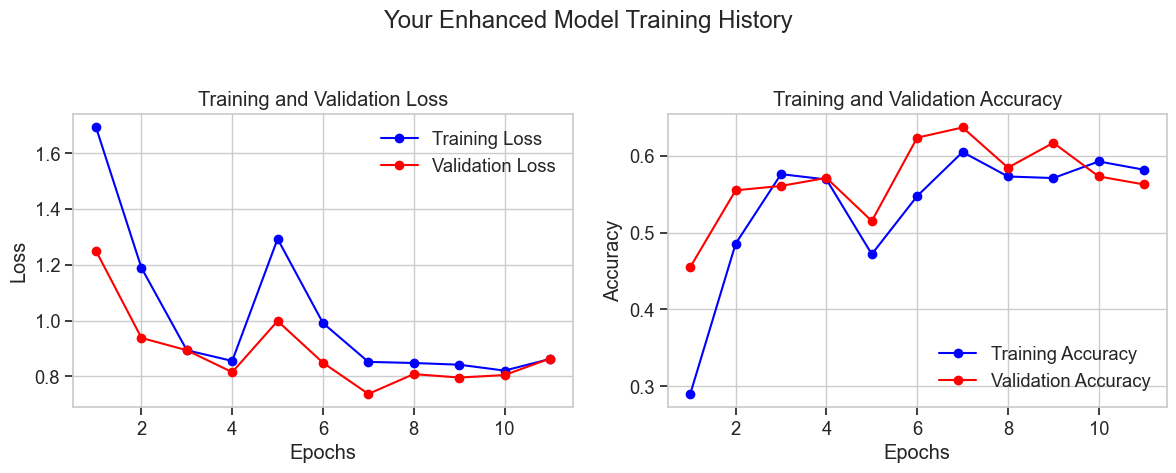

In [22]:
# ##### ADD YOUR CODE HERE ######
# Plot the learning curves for your enhanced model
draw_metric_hist(enhanced_history, title='Your Enhanced Model Training History')



--- Test Set Evaluation ---
Test Loss: 0.7341
Test Accuracy: 0.6476
Test F1 Score (Macro): 0.6149
Test F1 Score (Weighted): 0.6149

Classification Report:
                  precision    recall  f1-score   support

         Cepheid     0.9868    1.0000    0.9934       150
        RR Lyrae     0.9427    0.9867    0.9642       150
Eclipsing Binary     0.6000    0.7800    0.6783       150
     Delta Scuti     0.0000    0.0000    0.0000       150
             LPV     1.0000    1.0000    1.0000       150
      Flare Star     0.8649    0.2133    0.3422       150
  Rotational Mod     0.2312    0.5533    0.3261       150

        accuracy                         0.6476      1050
       macro avg     0.6608    0.6476    0.6149      1050
    weighted avg     0.6608    0.6476    0.6149      1050


Confusion Matrix:


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

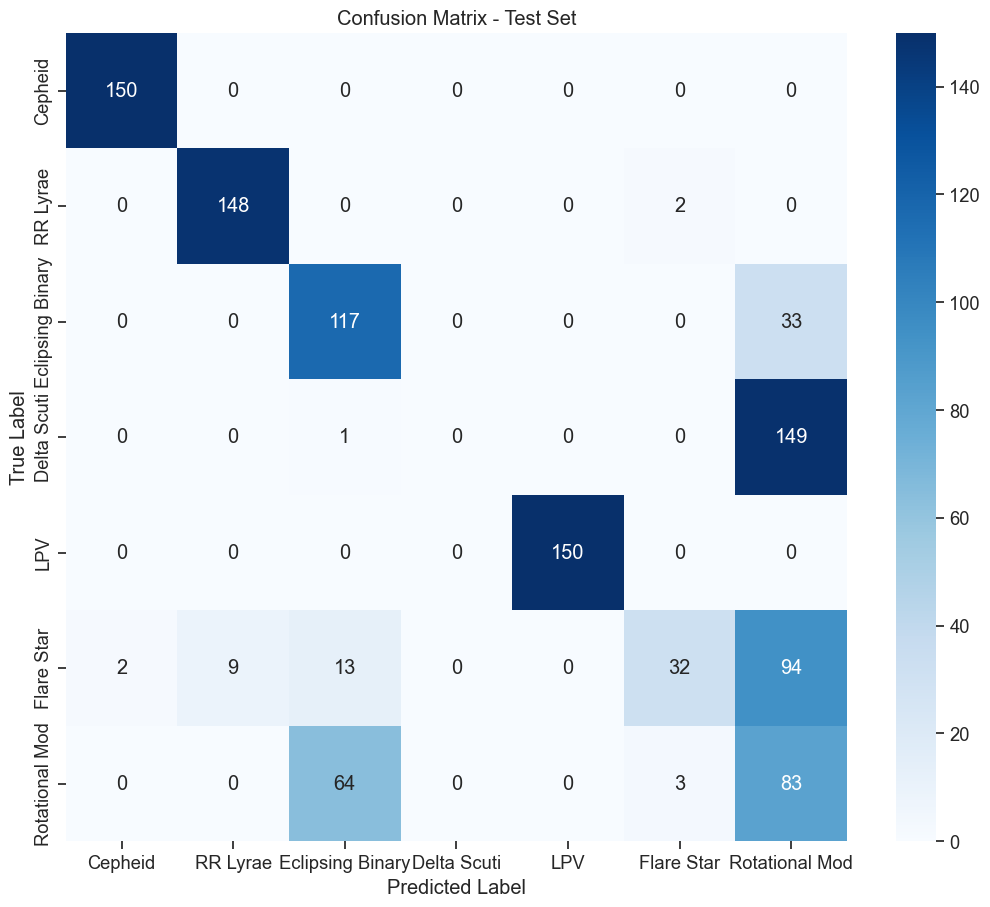

In [23]:
# ##### ADD YOUR CODE HERE ######
# Evaluate your enhanced model on the test set
enhanced_test_metrics = run_test(
    enhanced_model,
    test_loader,
    criterion,
    device,
    class_names=CLASS_NAMES,
    model_path="enhanced_model_best.pth"
)



 ## 6. Exercise Solution (Example)



 Below is an *example* of how you could have implemented an enhanced LSTM classifier. Remember, many different combinations of layers, bidirectionality, hidden size, and dropout could lead to improved results.

In [ ]:
# --- Example Solution: Enhanced GRU Classifier ---

class GRUEnhancedSolution(nn.Module):
    """Enhanced GRU Classifier for the Solution."""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_classes=NUM_CLASSES, dropout_prob=0.4, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                            batch_first=True,
                            dropout=dropout_prob if num_layers > 1 else 0, # Only apply RNN dropout if layers > 1
                            bidirectional=bidirectional)

        # Dropout layer after GRU
        self.dropout = nn.Dropout(dropout_prob)

        # Adjust linear layer input size
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)

    def forward(self, x):
        gru_out, _ = self.gru(x) # We only need the output sequence here

        # Get the output of the last time step (handles bidirectionality)
        last_timestep_output = gru_out[:, -1, :]

        # Apply dropout before the final layer
        out = self.dropout(last_timestep_output)

        # Final linear layer
        out = self.fc(out)
        return out

# --- Instantiate, Train, and Evaluate the Solution Example ---
print("\n--- Running Example Solution ---")

# Instantiate
solution_model = GRUEnhancedSolution(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    dropout_prob=0.4,
    bidirectional=True
).to(device)

print("\nSolution Model Structure:")
print(solution_model)

# Optimizer
criterion_sol = nn.CrossEntropyLoss()
optimizer_sol = optim.Adam(solution_model.parameters(), lr=0.0005)

# Train (using same parameters as exercise section for comparison)
solution_history = run_train(
    solution_model,
    train_loader,
    val_loader,
    criterion_sol,
    optimizer_sol,
    device,
    num_epochs=NUM_EPOCHS_ENHANCED, # Use same number of epochs as exercise
    model_name="solution_model_best.pth",
    patience=PATIENCE_ENHANCED # Use same patience
)

# Plot history
draw_metric_hist(solution_history, title='Example Solution Model Training History')

# Evaluate
solution_test_metrics = run_test(
    solution_model,
    test_loader,
    criterion_sol,
    device,
    class_names=CLASS_NAMES,
    model_path="solution_model_best.pth"
)



--- Running Example Solution ---

Solution Model Structure:
GRUEnhancedSolution(
  (gru): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)


c:\Users\39393\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/20 | Train Loss: 1.5713, Train Acc: 0.3243, Train F1: 0.3115 | Val Loss: 1.0840, Val Acc: 0.5352, Val F1: 0.4480
   -> Validation loss decreased. Saved best model to solution_model_best.pth
Epoch 2/20 | Train Loss: 0.9186, Train Acc: 0.5876, Train F1: 0.5818 | Val Loss: 0.7943, Val Acc: 0.6257, Val F1: 0.5782
   -> Validation loss decreased. Saved best model to solution_model_best.pth
Epoch 3/20 | Train Loss: 0.7227, Train Acc: 0.6641, Train F1: 0.6669 | Val Loss: 0.6372, Val Acc: 0.7933, Val F1: 0.7887
   -> Validation loss decreased. Saved best model to solution_model_best.pth
Epoch 4/20 | Train Loss: 0.6010, Train Acc: 0.7437, Train F1: 0.7428 | Val Loss: 0.5551, Val Acc: 0.8229, Val F1: 0.8215
   -> Validation loss decreased. Saved best model to solution_model_best.pth
Epoch 5/20 | Train Loss: 0.4401, Train Acc: 0.8600, Train F1: 0.8570 | Val Loss: 0.3336, Val Acc: 0.8943, Val F1: 0.8943
   -> Validation loss decreased. Saved best model to solution_model_best.pth


 ## 7. Comparison and Conclusions



 Let's compare the performance of the base models with the enhanced model you created (and optionally, the example solution).

In [ ]:
# --- Comparison of Test Results ---
print("\n--- Performance Comparison (Test Set) ---")

def get_metrics_summary(metrics_dict, model_name):
    """Extracts key metrics from the results dictionary."""
    if metrics_dict is None:
        print(f"Metrics for {model_name} are not available.")
        return {'Accuracy': float('nan'), 'F1 Macro': float('nan'), 'F1 Weighted': float('nan')}

    # Ensure metrics are tensors before converting
    acc = metrics_dict.get('accuracy')
    f1m = metrics_dict.get('f1_macro')
    f1w = metrics_dict.get('f1_weighted')

    return {
        'Accuracy': acc.cpu().item() if torch.is_tensor(acc) else float('nan'),
        'F1 Macro': f1m.cpu().item() if torch.is_tensor(f1m) else float('nan'),
        'F1 Weighted': f1w.cpu().item() if torch.is_tensor(f1w) else float('nan')
    }

summary_lstm_base = get_metrics_summary(lstm_base_test_metrics, "LSTM Base")
summary_gru_base = get_metrics_summary(gru_base_test_metrics, "GRU Base")
# Use the metrics from your trained enhanced model
summary_enhanced = get_metrics_summary(enhanced_test_metrics, "GRU Enhanced Model")
# Optionally include the solution example metrics
summary_solution = get_metrics_summary(solution_test_metrics, "Solution Example")


print("\nLSTM Base:")
for key, value in summary_lstm_base.items(): print(f"  {key}: {value:.4f}")

print("\nGRU Base:")
for key, value in summary_gru_base.items(): print(f"  {key}: {value:.4f}")

print("\nLSTM Enhanced Model:")
for key, value in summary_enhanced.items(): print(f"  {key}: {value:.4f}")

# Uncomment if you ran the solution example
print("\nGRU Solution Model:")
for key, value in summary_solution.items(): print(f"  {key}: {value:.4f}")


# --- Comparison Table (using Pandas) ---
try:
    import pandas as pd
    comparison_data = {
        'Model': ['LSTM Base', 'GRU Base', 'GRU Enhanced Model', 'GRU Solution'],
        'Accuracy': [summary_lstm_base['Accuracy'], summary_gru_base['Accuracy'], summary_enhanced['Accuracy'], summary_solution['Accuracy']],
        'F1 Macro': [summary_lstm_base['F1 Macro'], summary_gru_base['F1 Macro'], summary_enhanced['F1 Macro'], summary_solution['F1 Macro']],
        'F1 Weighted': [summary_lstm_base['F1 Weighted'], summary_gru_base['F1 Weighted'], summary_enhanced['F1 Weighted'], summary_solution['F1 Weighted']]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print("\n--- Comparison Table ---")
    print(comparison_df.round(4).to_string(index=False))
except ImportError:
    print("\nPandas not found. Cannot display comparison table.")
except Exception as e:
     print(f"\nError creating comparison table: {e}")



 **Discussion:**



 *   **What specific changes did you make to enhance the RNN model?** (e.g., Added bidirectionality, increased layers, added dropout?)

 *   **How did these changes affect performance compared to the base models?** Was there a significant improvement in accuracy or F1-score? Did it generalize better (comparing train vs. validation accuracy)?

 *   **Looking at the confusion matrix of your enhanced model, which classes are still being confused?** This might suggest further improvements or indicate inherent difficulties in distinguishing certain light curve types with this architecture.

 *   **What challenges did you encounter during the enhancement process?** (e.g., Managing tensor shapes, choosing hyperparameters, interpreting results?)



 **Conclusions:**



 This workshop demonstrated how to:

 1.  Generate and prepare specific types of astronomical time series data (Cepheid, RR Lyrae, Eclipsing Binary, 'Delta Scuti', 'LPV', 'Flare Star', 'Rotational Modulation') for classification with PyTorch.

 2.  Implement basic RNN models (LSTM and GRU).

 3.  Evaluate model performance and identify areas for improvement.

 4.  Enhance RNN architectures using techniques like multiple layers, bidirectionality, and dropout to potentially improve classification accuracy.



 Experimentation with different architectures and hyperparameters is key in deep learning for time series analysis. Even small architectural changes can significantly impact performance, especially on complex datasets like those often found in astronomy. More advanced techniques like Attention mechanisms or combined CNN-RNN models could potentially yield further improvements for this type of task.

 ---

 End of Workshop Notebook

 ---